In [24]:
import numpy as np
import rasterio
from matplotlib import pyplot as plt
from rasterio.plot import show, show_hist
from rasterio.features import shapes
from skimage.segmentation import quickshift, mark_boundaries
from skimage import io, color
from rasterstats import zonal_stats
import geopandas as gpd
from shapely.geometry import shape

# Read image and get basic statistics/image info

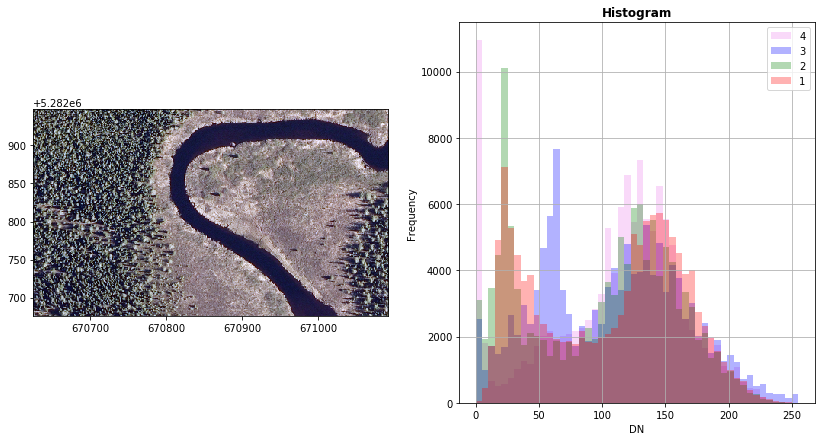

In [2]:
dataset = rasterio.open('/Users/aaron/gdrive/projects/segmentation_project/river_subset.tif')

fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
show(dataset, ax=axrgb)
show_hist(dataset, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

# Get image bounding box info
crs = dataset.crs
bounds = dataset.bounds
affine = dataset.transform#.to_gdal() 


# Segmentation

Quickshift number of segments: 406


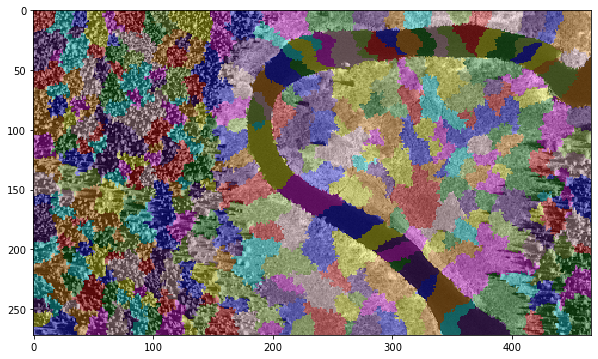

In [3]:
img = io.imread('/Users/aaron/gdrive/projects/segmentation_project/river_subset.tif')
segments = quickshift(img, kernel_size=3, convert2lab=False, max_dist=6, ratio=0.5).astype('int32')
print("Quickshift number of segments: %d" % len(np.unique(segments)))

# View the segments via Python
plt.figure(figsize=(10,10))
plt.imshow(color.label2rgb(segments, img))


# Calculate NDVI


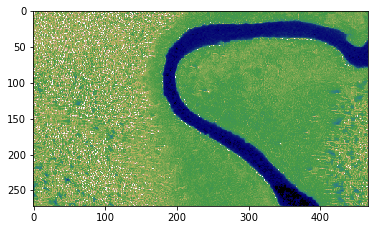

In [4]:
# http://www.loicdutrieux.net/pyLandsat/NDVI_calc.html
# https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-calculations.html
# https://gis.stackexchange.com/questions/138914/calculating-ndvi-with-rasterio

red = dataset.read(3).astype(float)
nir = dataset.read(4).astype(float)

#Allow 0 in division
np.seterr(divide='ignore', invalid='ignore')

ndvi = np.empty(dataset.shape, dtype=rasterio.float32)
check = np.logical_or ( red > 0, nir > 0 )
ndvi = np.where ( check,  (nir - red ) / ( nir + red ), -999 )
show(ndvi, cmap='gist_earth')
    

# Zonal Statistics

In [5]:
# https://automating-gis-processes.github.io/CSC18/lessons/L6/zonal-statistics.html
# https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html#zonal-statistics
# https://sgillies.net/2014/01/18/getting-shapes-of-raster-features-with-rasterio.html

polys = []
for shape, value in shapes(segments, transform=affine):
    polys.append(shape)

#from rasterstats import zonal_stats
#zs = zonal_stats(polys, ndvi, affine = affine, stats="mean")
zs = zonal_stats(polys, ndvi, affine = affine, stats="mean")

/Users/aaron/anaconda3/envs/rasterio/lib/python3.7/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [6]:
print(len(zs))
print(len(polys))



486
486


In [27]:
# https://gis.stackexchange.com/questions/343725/convert-geojson-to-geopandas-geodataframe

# Sanity check
# Convert json to geopandas df

geom = [shape(i) for i in polys]
polys_gdf = gpd.GeoDataFrame({'geometry':geom})

In [26]:
polys_gdf

,geometry
0,"POLYGON ((670625.002 5282947.795, 670625.002 5..."
1,"POLYGON ((670871.002 5282947.795, 670871.002 5..."
2,"POLYGON ((670971.002 5282947.795, 670971.002 5..."
3,"POLYGON ((670992.002 5282947.795, 670992.002 5..."
4,"POLYGON ((670923.002 5282947.795, 670923.002 5..."
...,...
481,"POLYGON ((670898.002 5282694.795, 670898.002 5..."
482,"POLYGON ((670913.002 5282699.795, 670913.002 5..."
483,"POLYGON ((670995.002 5282699.795, 670995.002 5..."
484,"POLYGON ((671055.002 5282702.795, 671055.002 5..."


# Sanity Check

In [58]:
import pandas as pd

se = pd.Series([f['mean'] for f in zs])
polys_gdf['ndvi'] = se.values

# Now export to shp to inspect results...
polys_gdf.crs = dataset.crs
polys_gdf.to_file("/Users/aaron/Desktop/temp/mypolys2.shp")


In [50]:
polys_gdf

,geometry,ndvi
0,"POLYGON ((670625.002 5282947.795, 670625.002 5...",0.359136
1,"POLYGON ((670871.002 5282947.795, 670871.002 5...",-0.080569
2,"POLYGON ((670971.002 5282947.795, 670971.002 5...",-0.018852
3,"POLYGON ((670992.002 5282947.795, 670992.002 5...",-0.056795
4,"POLYGON ((670923.002 5282947.795, 670923.002 5...",-0.046072
...,...,...
481,"POLYGON ((670898.002 5282694.795, 670898.002 5...",-0.034642
482,"POLYGON ((670913.002 5282699.795, 670913.002 5...",-0.020341
483,"POLYGON ((670995.002 5282699.795, 670995.002 5...",-0.911014
484,"POLYGON ((671055.002 5282702.795, 671055.002 5...",-0.098643
